# Index <a class="anchor" id="09.i"></a>

* [Exercise 1](#09.1)
* [Exercise 2](#09.2)
* [Exercise 3](#09.3)
* [Exercise 4](#09.4)
* [Exercise 5](#09.5)
* [Exercise 6](#09.6)

## Exercise 1 <a class="anchor" id="09.1"></a>
* [Index](#09.i)

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [1]:
import numpy as np
from numba import vectorize, float32, jit, cuda
from math import log, exp

In [2]:
A = np.array([2, 5, 10, 3, 8], dtype='float32')

@vectorize([float32(float32)], target='parallel', fastmath=True)
def vec_log(x):
    return log(x)

@vectorize([float32(float32)], target='parallel', fastmath=True)
def vec_exp(x):
    return exp(x)

print("Vectorized Log:", vec_log(A))
print("Vectorized Exp:", vec_exp(A))

Vectorized Log: [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
Vectorized Exp: [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


## Exercise 2 <a class="anchor" id="09.2"></a>
* [Index](#09.i)

Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

In [3]:
import numpy as np
from numba import vectorize, float32, jit, cuda

In [4]:
@vectorize([float32(float32)], target='parallel', fastmath=True)
def gaussian_pdf(x):
    sigma = 1
    mean  = 1
    return 1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-((x-mean)/sigma)**2 / 2)
    
def gaussian_pdf_np(x):
    sigma = 1
    mean  = 1
    return 1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-((x-mean)/sigma)**2 / 2)

In [5]:
size = 100000
xs = np.linspace(-3, 3, size, dtype='float32')

In [6]:
%timeit gaussian_pdf(xs)

139 µs ± 3.61 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [7]:
%timeit gaussian_pdf_np(xs)

514 µs ± 8.57 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Exercise 3 <a class="anchor" id="09.3"></a>
* [Index](#09.i)

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt
from numba import int16

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

#put your code here

In [9]:
@vectorize([int16(int16, int16)], target='parallel', fastmath=True)
def zero_suppress(x, threshold):
    if x < threshold:
        return 0
    else:
        return x

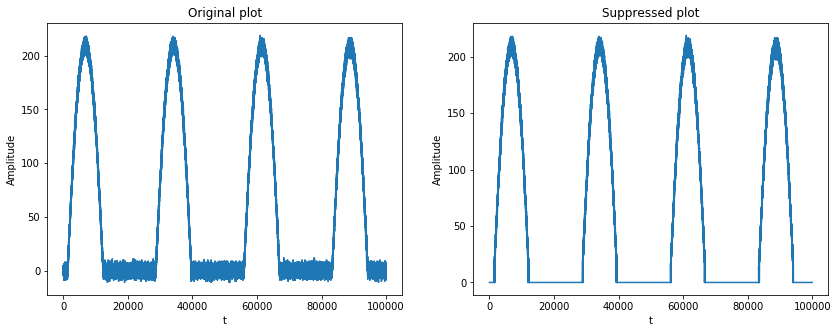

In [10]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(data)
plt.xlabel('t')
plt.ylabel('Amplitude')
plt.title('Original plot')

plt.subplot(1,2,2)
plt.plot(zero_suppress(data, 15))
plt.xlabel('t')
plt.ylabel('Amplitude')
plt.title('Suppressed plot')

plt.show()

## Exercise 4 <a class="anchor" id="09.4"></a>
* [Index](#09.i)

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [11]:
import numpy as np
import math

In [12]:
X = np.random.rand(3,3).astype('float64')
Y = np.random.rand(3,3).astype('float64')
res = np.zeros((3,3), dtype='float64')

In [13]:
@cuda.jit
def sigmoid_kernel(x, y, result, a, c):    
    
    row, col = cuda.grid(2)
    
    if row < result.shape[0] and col < result.shape[1]:
        tmp = 0.
        for k in range(x.shape[0]):
            tmp += x[k, row] * y[k, col]
        
        result[row, col] = math.tanh(a * tmp + c)

In [14]:
sigmoid_kernel[(1,1), (3,3)](X, Y, res, 1., 1.)

print(res)

[[0.97407035 0.96044091 0.95614815]
 [0.91376315 0.8340228  0.8880395 ]
 [0.95695508 0.97872096 0.93592884]]


## Exercise 5 <a class="anchor" id="09.5"></a>
* [Index](#09.i)

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [15]:
from numba import cuda
import numpy
import math

In [16]:
@cuda.jit
def cos_kernel(io_array):
    x, y, z = cuda.grid(3)
    if x < io_array.shape[0] and y < io_array.shape[1] and z < io_array.shape[2]:
        io_array[x][y][z] = math.cos(io_array[x][y][z])

In [17]:
array = np.random.normal(size=(256,256,256))

In [18]:
threadsperblock = (16, 16)
blockspergrid_x = int(math.ceil(array.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(array.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

In [19]:
cos_kernel[blockspergrid, threadsperblock](array)
print(array)

[[[ 0.96931968 -1.84787673  0.77966901 ...  0.25811695  0.89367337
    1.08177833]
  [-0.2232777  -0.47027907 -1.65988172 ... -0.01190913 -0.14650274
    1.11078407]
  [-0.18664853  0.32085503 -2.11284402 ... -0.00934217  0.66801719
    0.34041237]
  ...
  [ 0.73942116  1.58651102 -1.0382551  ... -0.23226822 -1.38060479
    1.28531455]
  [ 0.85019385  0.80936348  0.8127502  ... -1.07027633  1.29245597
    1.1881145 ]
  [ 0.94166234  0.08572106  0.30724097 ... -0.48091228  0.59927916
    0.19474952]]

 [[-0.44415847 -0.92434821 -1.04665553 ... -0.64938177  0.22507881
   -1.22472771]
  [ 0.6284676  -1.74881967 -0.82624145 ... -0.28845891  0.41401589
   -0.33201286]
  [ 0.75723261  0.13313031  0.49370362 ...  0.17857091  0.26900386
   -0.71461755]
  ...
  [ 0.99794862 -0.12177489 -0.11717515 ...  0.19462306  0.43621142
    1.26470881]
  [ 0.90157579  0.30814128  1.14098723 ...  0.24624166 -0.24195081
    0.96092204]
  [ 0.85238212 -1.58530468  0.66940336 ...  1.08128621 -0.68687467
    0.

## Exercise 6 <a class="anchor" id="09.6"></a>
* [Index](#09.i)

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [20]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.randint(100, size=(24,12))
B = np.random.randint(100, size=(12,22))

# Configure the blocks
threadsperblock = (24, 22)
blockspergrid_x = 1
blockspergrid_y = 1
blockspergrid = (blockspergrid_x, blockspergrid_y)

C = np.zeros((24,22))
matmul[blockspergrid, threadsperblock](A, B, C)

In [21]:
np.all(np.matmul(A,B) == C)

True